In [1]:
import os
import numpy as np
import pickle
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras import Input
from keras.layers import Flatten, Conv2D, MaxPool2D, Dropout, GlobalAveragePooling2D
from keras.layers import Dense, BatchNormalization, GlobalMaxPooling2D, MaxPooling2D
from sklearn.model_selection import train_test_split

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def save_dump(file_path, data, labels):
    file = open(file_path, 'wb')
    # dump information to that file
    pickle.dump((data, labels), file)
    # close the file
    file.close()
    pass


def load_data(path_file):
    file = open(path_file, 'rb')
    # dump information to that file
    (pixels, labels) = pickle.load(file)
    # close the file
    file.close()
    print(pixels.shape)
    print(labels.shape)
    return pixels, labels


def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(model_history.history[acc]) + 1), model_history.history[acc])
    axs[0].plot(range(1, len(model_history.history[val_acc]) + 1), model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history[acc]) + 1), len(model_history.history[acc]) / 10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']) / 10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    # plt.savefig('roc.png')


def plot_model_legend(model_history):
    # view
    accuracy = model_history.history['accuracy']
    val_accuracy = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation')
    plt.xlim(0, len(accuracy))
    plt.ylim(0, 1)
    plt.legend(loc='best')
    plt.show()
    

def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cmx, annot=True, fmt='g')
    print(cmx_data)
    plt.show()


# def print_ratio(y_true, y_pred):
#     labels = sorted(list(set(y_true)))
#     cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
#     cmx_ratio = [[cmx_data[0][0]/(cmx_data[0][0] + cmx_data[0][1]), cmx_data[0][1]/(cmx_data[0][0] + cmx_data[0][1])],
#                  [cmx_data[1][0]/(cmx_data[1][0] + cmx_data[1][1]), cmx_data[1][1]/(cmx_data[1][0] + cmx_data[1][1])] ]
#     df_cmx = pd.DataFrame(cmx_ratio, index=labels, columns=labels)
#     plt.figure(figsize = (10,7))
#     sn.heatmap(df_cmx, annot=True)
#     print(cmx_ratio)
#     plt.show()


# Analytics data
def view_analytics_data_post(people, performance):
    plt.rcdefaults()
    fig, ax = plt.subplots()

    # Data
    y_pos = np.arange(len(people))
    error = np.random.rand(len(people))

    ax.barh(y_pos, performance, xerr=error, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(people)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Performance')
    ax.set_title('Analytics')
    plt.show()

def view_data(global_labels_not_one_hot):
    label_unique = np.unique(global_labels_not_one_hot)
    data_view = []
    for lb in label_unique: 
        data_view.append(sum(global_labels_not_one_hot == lb))
    view_analytics_data_post(label_unique, data_view)

In [5]:
data_train_1, labels_train_1 = load_data("/content/drive/MyDrive/GHTK/RnD/Data/3x768x1/1000_post/data_train_1.data")
data_train_2, labels_train_2 = load_data("/content/drive/MyDrive/GHTK/RnD/Data/3x768x1/1000_post/data_train_2.data")
# data_train_3, labels_train_3 = load_data("/content/drive/MyDrive/GHTK/RnD/Data/3x768x1/data_train_3.data")
# data_train_4, labels_train_4 = load_data("/content/drive/MyDrive/GHTK/RnD/Data/3x768x1/data_train_4.data")

(6000, 3, 768, 1)
(6000,)
(4000, 3, 768, 1)
(4000,)


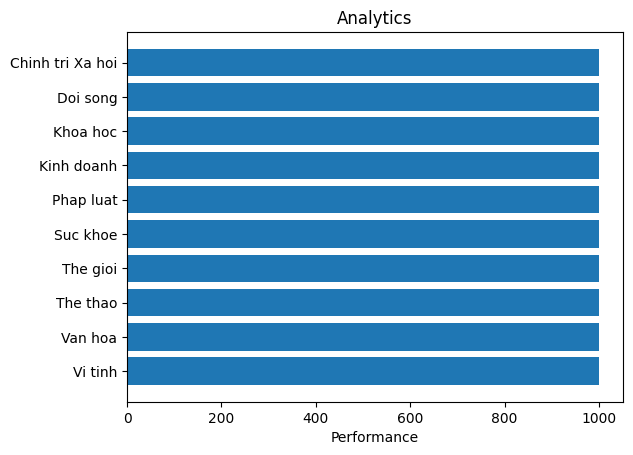

In [6]:
global_dataset = np.concatenate((data_train_1, data_train_2), axis=0)
global_labels = np.concatenate((labels_train_1, labels_train_2), axis=None)

view_data(global_labels)


In [7]:
lb = LabelBinarizer()
global_labels = lb.fit_transform(global_labels)

global_dataset.shape, global_labels.shape

((10000, 3, 768, 1), (10000, 10))

In [19]:
class_number = len(global_labels[0])
ip_shape = global_dataset[0].shape

model = Sequential()
model.add(Conv2D(128, kernel_size=(5, 5), input_shape=(ip_shape), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(class_number, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
weights_init = model.get_weights()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 3, 768, 128)       3328      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 384, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 384, 32)        102432    
                                                                 
 batch_normalization_1 (Batc  (None, 1, 384, 32)       128       
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dropout_2 (Dropout)         (None, 12288)            

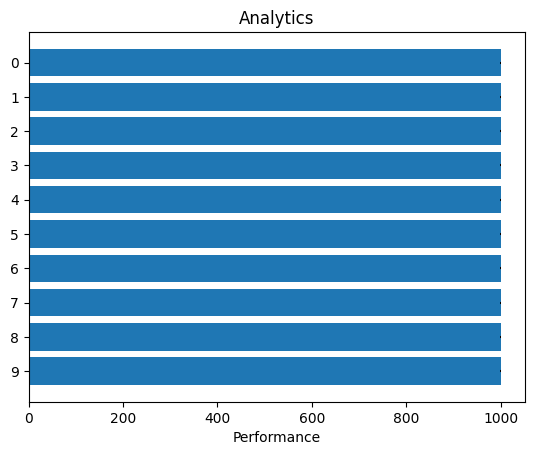

((10000, 3, 768, 1), array([0, 0, 0, ..., 9, 9, 9]))

In [9]:
# training ROC
global_labels_not_one_hot = np.argmax(global_labels, axis=1)
view_data(global_labels_not_one_hot)


global_dataset.shape, global_labels_not_one_hot

In [ ]:
X = global_dataset
y = global_labels_not_one_hot
k_fold = 10

from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=100)
for train, test in kfold.split(X, y):
    print(type(X[train]))
    print(X[train].shape)
    print(type(y[test]))
    print(y[test].shape)
    # view_data(y[train])
    # view_data(y[test])

In [ ]:
fold_dict={}
fold_dict['y_test']=y[test]

pred_folds_list=[]
cvscores = []
cnt_kfold = 1
for train, test in kfold.split(X, y):
    print("K-Fold =", cnt_kfold)

    fold_dict=dict()

    y_train_one_hot = tf.keras.utils.to_categorical(y[train], num_classes=class_number)
    y_test_one_hot = tf.keras.utils.to_categorical(y[test], num_classes=class_number)

    model.set_weights(weights_init)
    model.fit(X[train], y_train_one_hot, epochs=50, batch_size=16, verbose='auto', shuffle=True)
    # evaluate the model
    scores = model.evaluate(X[test], y_test_one_hot, verbose='auto')
    
    fold_dict['y_test']=y_test_one_hot
    fold_dict['y_pred']=model.predict(X[test])
    pred_folds_list.append(fold_dict)
    
    print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    cnt_kfold += 1
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

----ROC [ 1 ]----
Accuracy: 88.00 %
              precision    recall  f1-score   support

     Class 0       0.84      0.71      0.77       100
     Class 1       0.86      0.85      0.85       100
     Class 2       0.86      0.87      0.87       100
     Class 3       0.85      0.85      0.85       100
     Class 4       0.86      0.92      0.89       100
     Class 5       0.91      0.91      0.91       100
     Class 6       0.87      0.84      0.85       100
     Class 7       0.97      0.94      0.95       100
     Class 8       0.92      0.97      0.95       100
     Class 9       0.86      0.94      0.90       100

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000

[[71  3  2  6 10  2  1  0  2  3]
 [ 0 85  1  1  1  2  4  1  3  2]
 [ 1  5 87  0  0  3  1  1  0  2]
 [ 5  3  0 85  2  0  0  0  0  5]
 [ 6  0  0  0 92  0  1  1  0  0]
 [ 1  2  4  0  0 91  2  0  0  0]
 [ 1  0

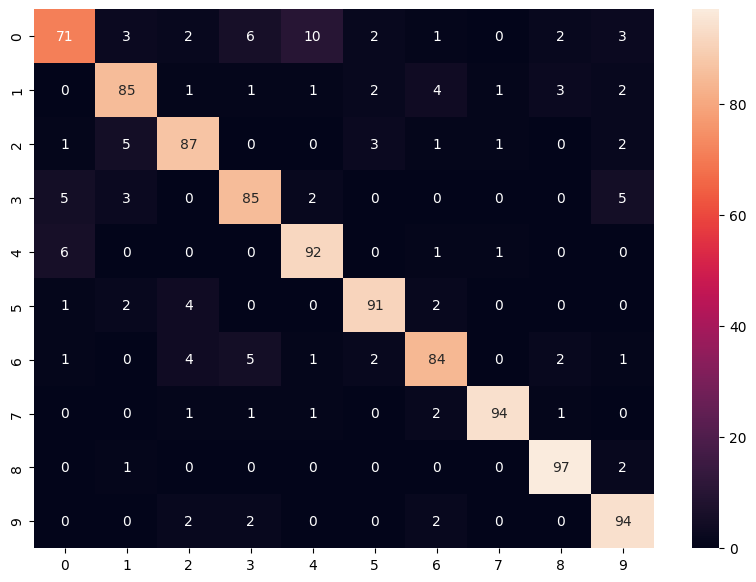

----ROC [ 2 ]----
Accuracy: 88.60 %
              precision    recall  f1-score   support

     Class 0       0.73      0.83      0.78       100
     Class 1       0.90      0.81      0.85       100
     Class 2       0.85      0.88      0.86       100
     Class 3       0.87      0.84      0.85       100
     Class 4       0.91      0.84      0.87       100
     Class 5       0.91      0.95      0.93       100
     Class 6       0.90      0.91      0.91       100
     Class 7       0.98      0.97      0.97       100
     Class 8       0.91      0.92      0.92       100
     Class 9       0.93      0.91      0.92       100

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000

[[83  3  0  4  2  1  0  0  5  2]
 [ 5 81  3  1  1  2  2  1  3  1]
 [ 3  3 88  0  0  3  2  0  1  0]
 [ 3  1  3 84  1  0  4  0  0  4]
 [12  1  0  2 84  1  0  0  0  0]
 [ 2  0  2  0  0 95  1  0  0  0]
 [ 0  0

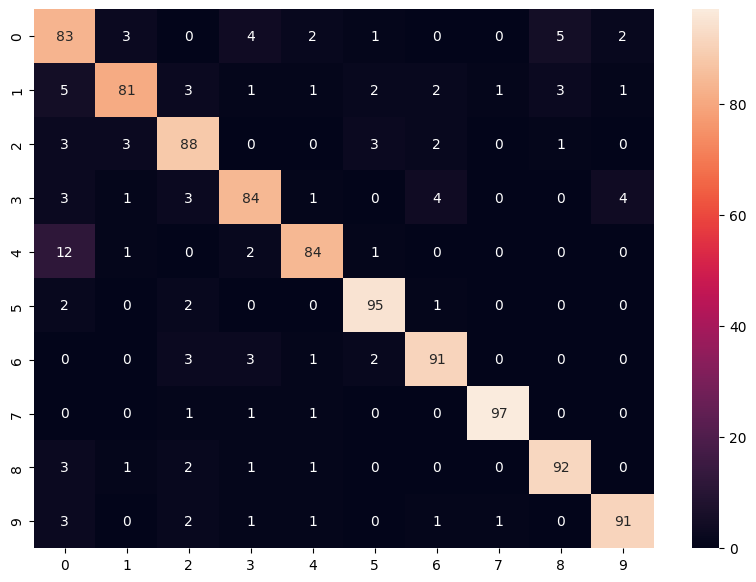

----ROC [ 3 ]----
Accuracy: 88.40 %
              precision    recall  f1-score   support

     Class 0       0.70      0.82      0.76       100
     Class 1       0.81      0.77      0.79       100
     Class 2       0.85      0.88      0.86       100
     Class 3       0.89      0.85      0.87       100
     Class 4       0.95      0.93      0.94       100
     Class 5       0.90      0.87      0.88       100
     Class 6       0.91      0.95      0.93       100
     Class 7       1.00      0.97      0.98       100
     Class 8       0.97      0.85      0.90       100
     Class 9       0.91      0.95      0.93       100

    accuracy                           0.88      1000
   macro avg       0.89      0.88      0.89      1000
weighted avg       0.89      0.88      0.89      1000

[[82  4  2  6  2  3  0  0  1  0]
 [11 77  4  3  1  4  0  0  0  0]
 [ 2  4 88  0  0  2  1  0  0  3]
 [ 6  1  1 85  0  0  4  0  0  3]
 [ 3  3  1  0 93  0  0  0  0  0]
 [ 3  1  6  0  0 87  3  0  0  0]
 [ 2  0

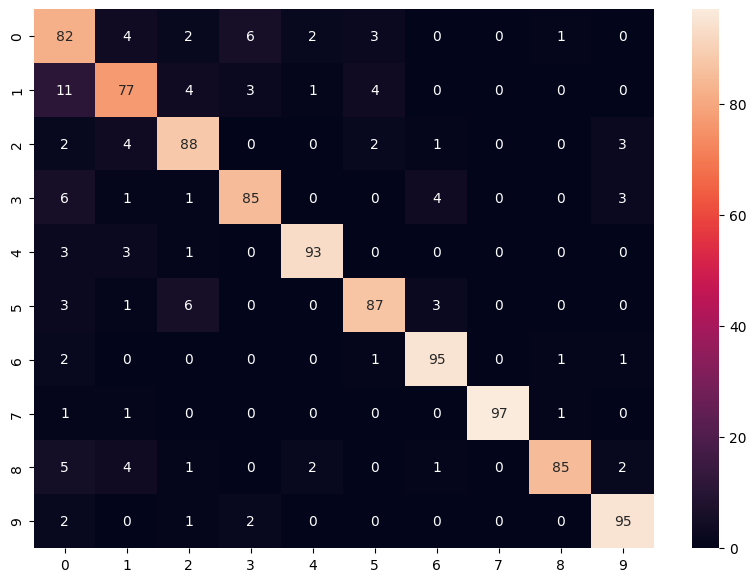

----ROC [ 4 ]----
Accuracy: 89.50 %
              precision    recall  f1-score   support

     Class 0       0.72      0.82      0.77       100
     Class 1       0.91      0.92      0.92       100
     Class 2       0.89      0.87      0.88       100
     Class 3       0.91      0.84      0.87       100
     Class 4       0.89      0.93      0.91       100
     Class 5       0.87      0.90      0.88       100
     Class 6       0.96      0.88      0.92       100
     Class 7       0.97      0.96      0.96       100
     Class 8       0.96      0.92      0.94       100
     Class 9       0.92      0.91      0.91       100

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000

[[82  2  1  1  7  2  0  2  0  3]
 [ 1 92  2  0  0  3  0  0  2  0]
 [ 3  3 87  0  0  5  0  0  0  2]
 [15  0  0 84  0  0  1  0  0  0]
 [ 4  0  0  3 93  0  0  0  0  0]
 [ 4  1  3  1  0 90  1  0  0  0]
 [ 1  1

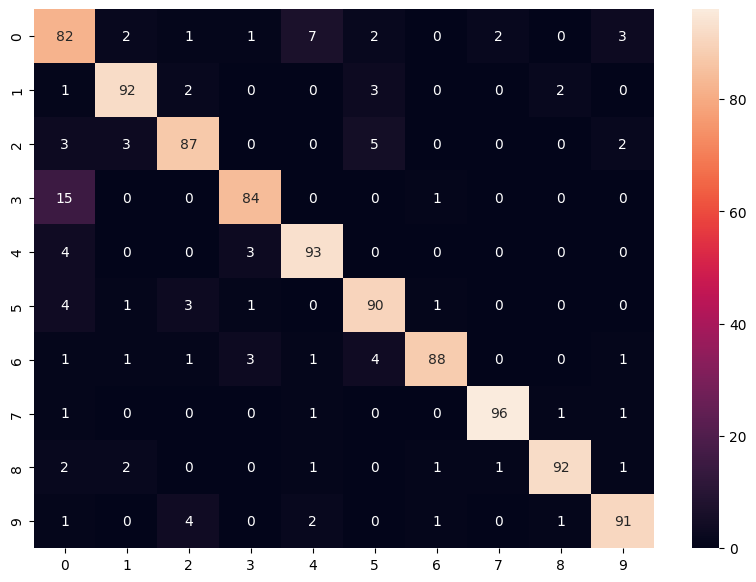

----ROC [ 5 ]----
Accuracy: 88.80 %
              precision    recall  f1-score   support

     Class 0       0.82      0.77      0.79       100
     Class 1       0.86      0.82      0.84       100
     Class 2       0.88      0.74      0.80       100
     Class 3       0.86      0.90      0.88       100
     Class 4       0.89      0.93      0.91       100
     Class 5       0.88      0.95      0.91       100
     Class 6       0.90      0.89      0.89       100
     Class 7       0.98      0.99      0.99       100
     Class 8       0.90      0.94      0.92       100
     Class 9       0.91      0.95      0.93       100

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000

[[77  4  0  6  8  0  1  0  3  1]
 [ 2 82  4  1  1  2  1  2  5  0]
 [ 4  3 74  1  0  5  6  0  2  5]
 [ 5  1  0 90  1  0  1  0  0  2]
 [ 3  1  1  1 93  1  0  0  0  0]
 [ 0  1  4  0  0 95  0  0  0  0]
 [ 0  0

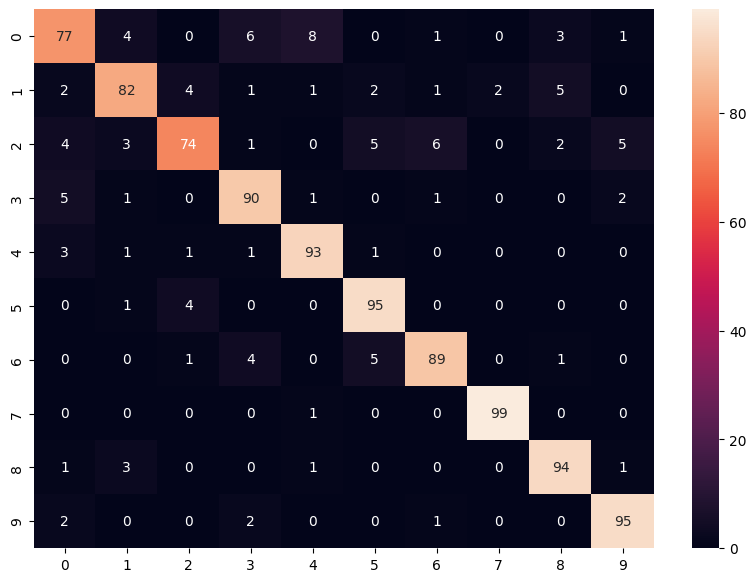

----ROC [ 6 ]----
Accuracy: 88.50 %
              precision    recall  f1-score   support

     Class 0       0.71      0.75      0.73       100
     Class 1       0.90      0.80      0.85       100
     Class 2       0.82      0.89      0.86       100
     Class 3       0.92      0.87      0.89       100
     Class 4       0.87      0.93      0.90       100
     Class 5       0.90      0.87      0.88       100
     Class 6       0.92      0.97      0.94       100
     Class 7       0.98      0.96      0.97       100
     Class 8       0.90      0.88      0.89       100
     Class 9       0.97      0.93      0.95       100

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000

[[75  1  0  5 10  3  2  0  3  1]
 [ 9 80  2  0  1  1  2  1  4  0]
 [ 1  4 89  1  0  3  0  1  1  0]
 [ 6  1  2 87  1  0  2  0  0  1]
 [ 4  1  0  0 93  1  0  0  0  1]
 [ 2  1  8  0  0 87  1  0  1  0]
 [ 0  0

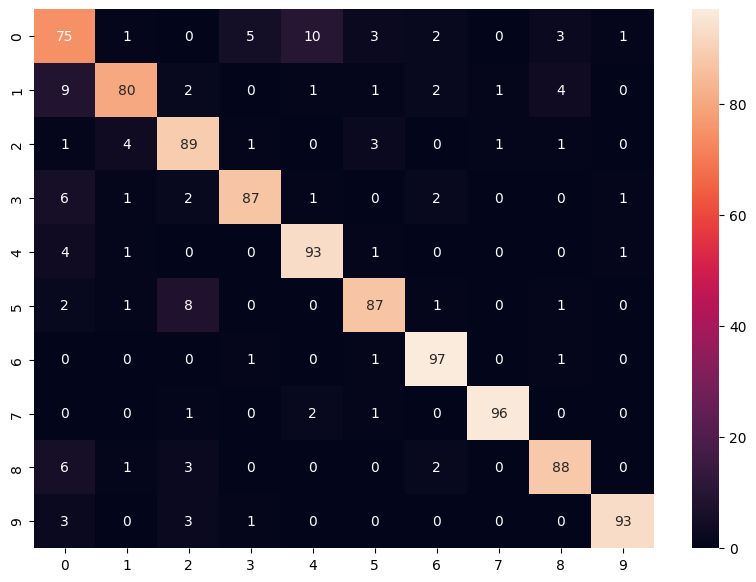

----ROC [ 7 ]----
Accuracy: 88.60 %
              precision    recall  f1-score   support

     Class 0       0.77      0.76      0.76       100
     Class 1       0.87      0.87      0.87       100
     Class 2       0.88      0.80      0.84       100
     Class 3       0.89      0.85      0.87       100
     Class 4       0.93      0.94      0.94       100
     Class 5       0.87      0.89      0.88       100
     Class 6       0.90      0.89      0.89       100
     Class 7       0.98      0.98      0.98       100
     Class 8       0.85      0.94      0.90       100
     Class 9       0.92      0.94      0.93       100

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000

[[76  4  2  4  2  1  3  1  6  1]
 [ 2 87  2  1  0  3  1  0  3  1]
 [ 2  2 80  0  0  8  1  0  3  4]
 [ 9  1  0 85  2  0  1  0  1  1]
 [ 5  1  0  0 94  0  0  0  0  0]
 [ 2  1  4  0  1 89  2  1  0  0]
 [ 0  1

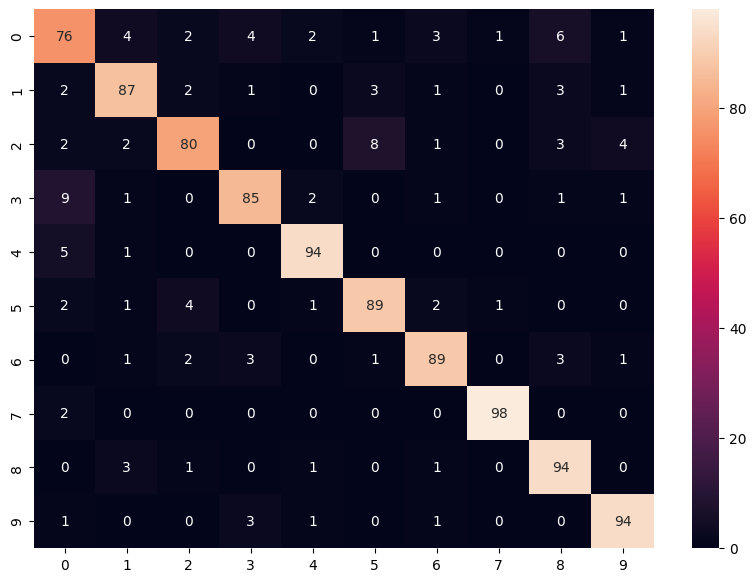

----ROC [ 8 ]----
Accuracy: 89.60 %
              precision    recall  f1-score   support

     Class 0       0.79      0.79      0.79       100
     Class 1       0.85      0.88      0.86       100
     Class 2       0.90      0.90      0.90       100
     Class 3       0.89      0.84      0.87       100
     Class 4       0.88      0.93      0.90       100
     Class 5       0.95      0.89      0.92       100
     Class 6       0.91      0.92      0.92       100
     Class 7       0.99      0.97      0.98       100
     Class 8       0.88      0.91      0.90       100
     Class 9       0.93      0.93      0.93       100

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000

[[79  4  3  4  6  1  0  0  2  1]
 [ 1 88  1  0  2  0  1  1  6  0]
 [ 0  4 90  0  0  2  1  0  0  3]
 [ 6  0  0 84  1  0  5  0  1  3]
 [ 7  0  0  0 93  0  0  0  0  0]
 [ 2  0  4  2  1 89  2  0  0  0]
 [ 3  1

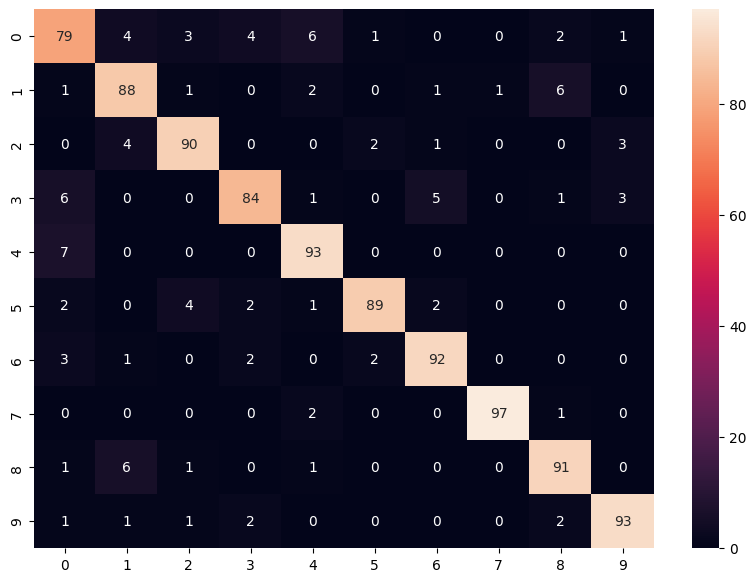

----ROC [ 9 ]----
Accuracy: 87.10 %
              precision    recall  f1-score   support

     Class 0       0.78      0.62      0.69       100
     Class 1       0.82      0.88      0.85       100
     Class 2       0.78      0.87      0.82       100
     Class 3       0.84      0.89      0.86       100
     Class 4       0.85      0.91      0.88       100
     Class 5       0.90      0.86      0.88       100
     Class 6       0.84      0.87      0.86       100
     Class 7       0.98      0.96      0.97       100
     Class 8       0.95      0.97      0.96       100
     Class 9       0.97      0.88      0.92       100

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000

[[62 10  3  8 11  2  2  0  2  0]
 [ 2 88  3  1  2  2  0  0  1  1]
 [ 1  3 87  0  1  4  3  0  0  1]
 [ 1  0  1 89  1  0  6  0  1  1]
 [ 2  0  1  3 91  0  1  2  0  0]
 [ 3  3  5  0  0 86  3  0  0  0]
 [ 1  1

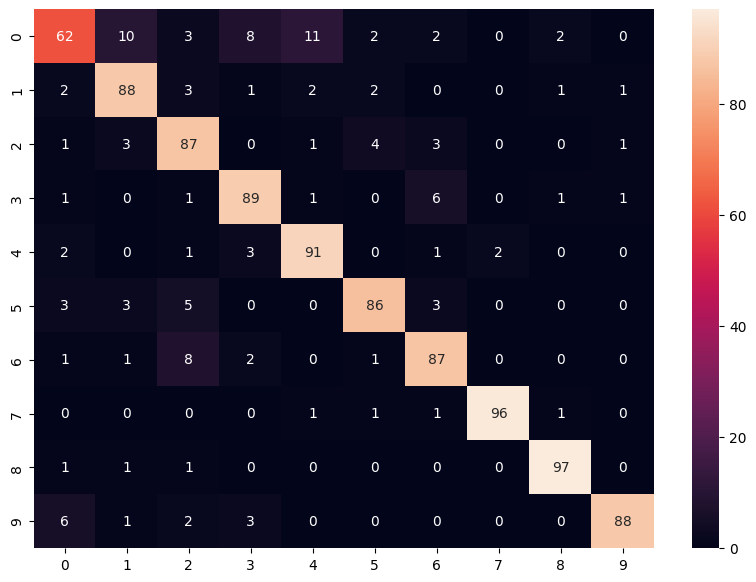

----ROC [ 10 ]----
Accuracy: 89.90 %
              precision    recall  f1-score   support

     Class 0       0.72      0.84      0.78       100
     Class 1       0.88      0.91      0.90       100
     Class 2       0.93      0.90      0.91       100
     Class 3       0.85      0.86      0.86       100
     Class 4       0.99      0.82      0.90       100
     Class 5       0.97      0.91      0.94       100
     Class 6       0.88      0.92      0.90       100
     Class 7       0.95      0.97      0.96       100
     Class 8       0.95      0.93      0.94       100
     Class 9       0.92      0.93      0.93       100

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000

[[84  1  1  7  0  1  1  1  1  3]
 [ 0 91  2  1  0  0  1  1  4  0]
 [ 2  2 90  1  0  1  3  0  0  1]
 [ 8  1  0 86  1  0  1  0  0  3]
 [13  0  0  1 82  1  0  3  0  0]
 [ 2  3  2  1  0 91  1  0  0  0]
 [ 3  

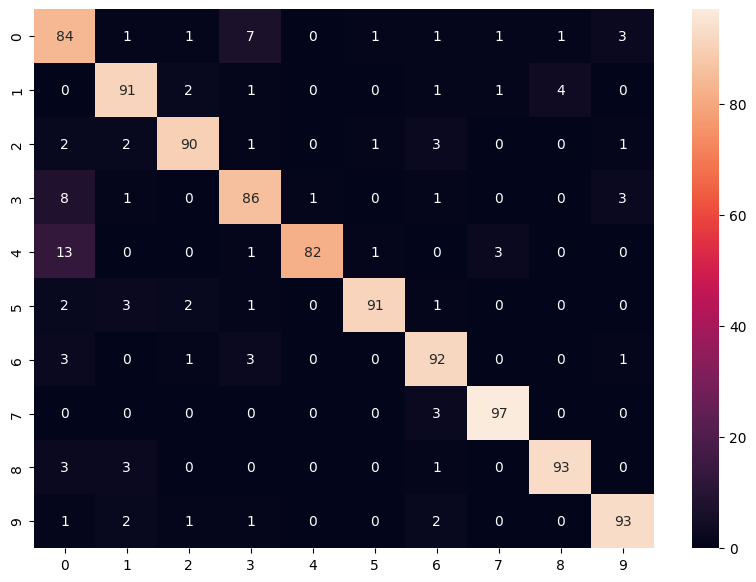

In [12]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, plot_confusion_matrix, plot_roc_curve, classification_report

i = 1
for idx, item in enumerate(pred_folds_list):
    print("----ROC [", i, "]----")
    # Report
    y_test = item['y_test']
    y_pred = item['y_pred']

    y_test = np.argmax(y_test, axis=1)
    y_target = np.argmax(y_pred, axis=1)

    print("Accuracy: %.2f %%" % (100 * accuracy_score(y_test, y_target)))

    class_number = len(np.unique(y_test))
    target_names = ["Class {}".format(i) for i in range(class_number)]
    print(classification_report(y_test, y_target, target_names=target_names))

    print_cmx(y_test, y_target)
    i += 1

In [13]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import RocCurveDisplay

i = 1
avg_score = []
for idx, item in enumerate(pred_folds_list):
    y_test = item['y_test']
    y_pred = item['y_pred']

    y_test = np.argmax(y_test, axis=1)
    # print(y_pred)
    score = roc_auc_score(y_test, y_pred, multi_class='ovr')
    avg_score.append(score)
    print("ROC", i ,": %.4f" % score)
    i += 1
print("AVG ROC = %.4f" % np.average(avg_score))

ROC 1 : 0.9910
ROC 2 : 0.9933
ROC 3 : 0.9909
ROC 4 : 0.9920
ROC 5 : 0.9908
ROC 6 : 0.9912
ROC 7 : 0.9904
ROC 8 : 0.9927
ROC 9 : 0.9896
ROC 10 : 0.9941
AVG ROC = 0.9916


In [14]:
data_train, data_test, labels_train, labels_test = train_test_split(global_dataset, global_labels, test_size=0.2, 
                                                                    random_state=100, shuffle=True, stratify=global_labels)


train_data, valid_data, train_labels, valid_labels = train_test_split(data_train, labels_train, test_size=0.2, 
                                                                      random_state=100, shuffle=True, stratify=labels_train)

data_train.shape, data_test.shape, labels_train.shape, labels_test.shape, train_data.shape, valid_data.shape, train_labels.shape, valid_labels.shape

((8000, 3, 768, 1),
 (2000, 3, 768, 1),
 (8000, 10),
 (2000, 10),
 (6400, 3, 768, 1),
 (1600, 3, 768, 1),
 (6400, 10),
 (1600, 10))

In [ ]:
model.set_weights(weights_init)
model_history = model.fit(train_data, train_labels, epochs=50, batch_size=16, verbose='auto', 
                          validation_data=(valid_data, valid_labels), shuffle=True)

plot_model_history(model_history)
# plot_model_legend(model_history)

In [16]:
test_eval = model.evaluate(data_test, labels_test, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

63/63 [==============================] - 1s 9ms/step - loss: 0.4999 - accuracy: 0.8735
Test loss: 0.49992236495018005
Test accuracy: 0.8734999895095825


Accuracy: 87.35 %
              precision    recall  f1-score   support

     Class 0       0.75      0.77      0.76       200
     Class 1       0.82      0.89      0.86       200
     Class 2       0.87      0.79      0.83       200
     Class 3       0.85      0.83      0.84       200
     Class 4       0.91      0.87      0.89       200
     Class 5       0.91      0.87      0.89       200
     Class 6       0.85      0.88      0.86       200
     Class 7       0.99      0.96      0.97       200
     Class 8       0.90      0.95      0.92       200
     Class 9       0.90      0.92      0.91       200

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000

[[153   8   1  12  11   1   4   2   5   3]
 [  6 178   2   0   1   2   0   0  10   1]
 [  6  14 158   2   0   9   3   0   1   7]
 [ 11   3   1 167   1   0  10   0   0   7]
 [ 15   2   1   7 174   0   1   0   0   0]
 [  4   

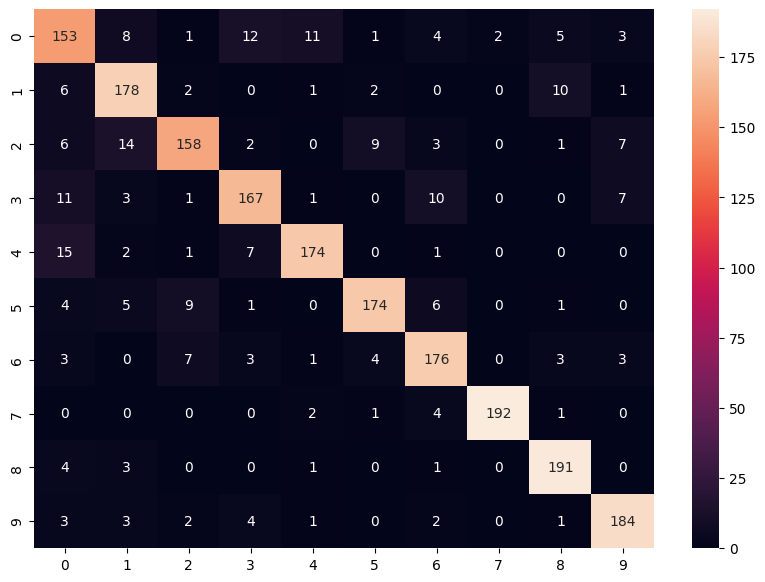

In [17]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix, plot_roc_curve, classification_report, auc

y_predict = model.predict(data_test)
y_target = np.argmax(y_predict, axis=1)
y_test = np.argmax(labels_test, axis=1)
print("Accuracy: %.2f %%" % (100 * accuracy_score(y_test, y_target)))

target_names = ["Class {}".format(i) for i in range(class_number)]
print(classification_report(y_test, y_target, target_names=target_names))

print_cmx(y_test, y_target)
# print_ratio(y_test, y_target)

In [ ]:
model.save('/content/drive/MyDrive/GHTK/RnD/test/models/cnn_nlp_text_classification_10_classer.h5', save_format='h5')